In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

# import matplotlib.pyplot as plt

from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.datasets.danish_data import load
from statsmodels.tsa.api import ARDL

In [51]:
import numpy
import pandas
import scipy
import statsmodels
import matplotlib

print(numpy.__version__)     # 1.26.4
print(pandas.__version__)    # 2.2.2
print(scipy.__version__)
print(statsmodels.__version__)
print(matplotlib.__version__)




1.26.4
2.2.2
1.17.0
0.14.6
3.10.8


# data

In [7]:
# TODO data train test target

df_tr = pd.read_csv('D:\Eduson_data\sibur_train_features.csv')

df_ts = pd.read_csv('D:\Eduson_data\sibur_test_features.csv')

df_tg = pd.read_csv('D:\Eduson_data\sibur_train_targets.csv')

df_sb = pd.read_csv('D:\Eduson_data\sibur_sample_submission.csv')

print(df_tr.columns)
print(df_ts.columns)
print(df_tr.shape, df_ts.shape, df_tg.shape, df_sb.shape)


# data[data.index.day == 9]

df_tr.index.dtype

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'],
      dtype='object')
Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'],
      dtype='object')
(5808, 11) (3984, 11) (5808, 5) (3984, 5)


dtype('int64')

In [3]:
# df_tr['timestamp'] = pd.to_datetime(df_tr['timestamp'])  # трансформ признака из str в timestamp 
# df_tr.set_index('timestamp', inplace=True)  # трансформ Признака timestamp в Индекс timestamp 
# df_tr.sort_index(inplace=True) # Сортируем для перестраховки
# df = df_tr.iloc[0: 10, :]  # For Train

# TODO в train, test и target преобразуем 'timestamp' из object -> Timestamp
df_tr['timestamp'] = pd.to_datetime(df_tr['timestamp'])
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'])
df_tg['timestamp'] = pd.to_datetime(df_tg['timestamp'])

# TODO 'timestamp' перенесём в индекс + сортировка индекса train, test, target  
df_tr = df_tr.set_index('timestamp')
df_tr = df_tr.sort_index()

df_ts = df_ts.set_index('timestamp')
df_ts = df_ts.sort_index()

df_tg = df_tg.set_index('timestamp')
df_tg = df_tg.sort_index()

print(df_tr.shape, df_ts.shape, df_tg.shape)

# df_tr.info()
# df_ts.info()
# df_tg.info()

print(df_tr.columns)
print(df_ts.columns)
print(df_tg.columns)

df_tr.head(2)

df_tg['B_C2H6']


(5808, 10) (3984, 10) (5808, 4)
Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'],
      dtype='object')
Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'],
      dtype='object')
Index(['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10'], dtype='object')


timestamp
2020-01-01 00:00:00    4.561979
2020-01-01 00:30:00    4.550741
2020-01-01 01:00:00    4.506793
2020-01-01 01:30:00    4.584963
2020-01-01 02:00:00    4.607483
                         ...   
2020-04-30 21:30:00    4.816865
2020-04-30 22:00:00    4.993286
2020-04-30 22:30:00    5.101574
2020-04-30 23:00:00    5.210675
2020-04-30 23:30:00    5.136487
Name: B_C2H6, Length: 5808, dtype: float64


** `pandas plot` по оси Х откладывает шаг равный `infer_freq=30min` **

<Axes: xlabel='timestamp'>

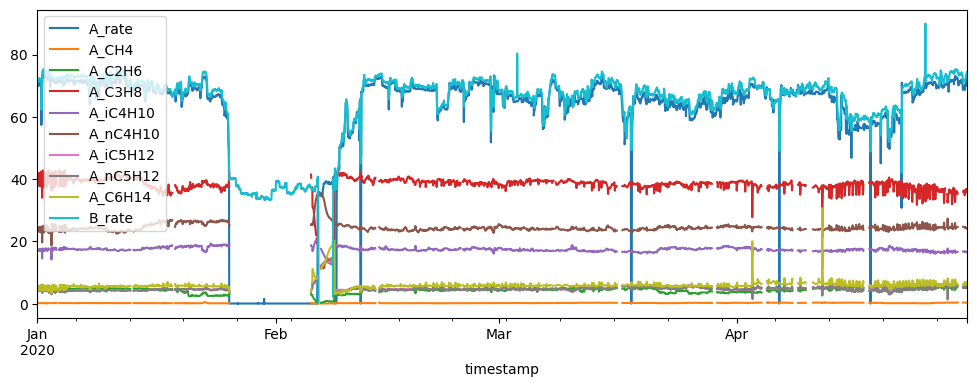

In [4]:
df_tr.plot(figsize=(12,4))

<Axes: xlabel='timestamp'>

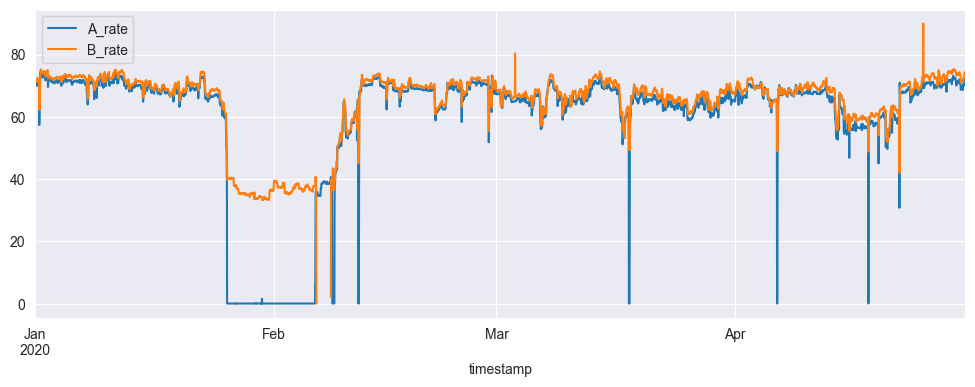

In [11]:
df_tr[['A_rate', 'B_rate']].plot(figsize=(12, 4))

In [6]:

df_sb.columns
df_tr.index

RangeIndex(start=0, stop=5808, step=1)

# acf 

**Правильный acf для анализа лагов**

* `Для 1-мерного ОБ применяем метод diff и удаяем NaN` 
* `Для acf строго убирать NaN`




In [12]:
# x_tr_A_iC4H10 = df_tr.dropna(axis=0)

# TODO diff() - всегда первый результат NaN, поэтому обязательно dropna
x_tr_A_iC4H10 = df_tr['A_iC4H10'].diff().dropna(axis=0)

print(x_tr_A_iC4H10)

print(df_tr.isna().any().any())

df_tr.shape

timestamp
2020-01-01 05:00:00    0.376032
2020-01-01 05:30:00   -0.086883
2020-01-01 06:00:00   -0.255199
2020-01-01 06:30:00   -0.133377
2020-01-01 07:00:00    0.225530
                         ...   
2020-04-30 21:30:00   -0.062531
2020-04-30 22:00:00   -0.025347
2020-04-30 22:30:00    0.051660
2020-04-30 23:00:00    0.059387
2020-04-30 23:30:00    0.089633
Name: A_iC4H10, Length: 4804, dtype: float64
True


(5808, 10)


# H_0 - Автокореляция между признаком и его лагами =0

**После diff:**

    * тренд убрали
    * осталась «чистая» автокорреляция
    * значимыми стали только отдельные лаги

`Это и есть цель diff.`

**Лаги вылезшие за зону CI - полезные**

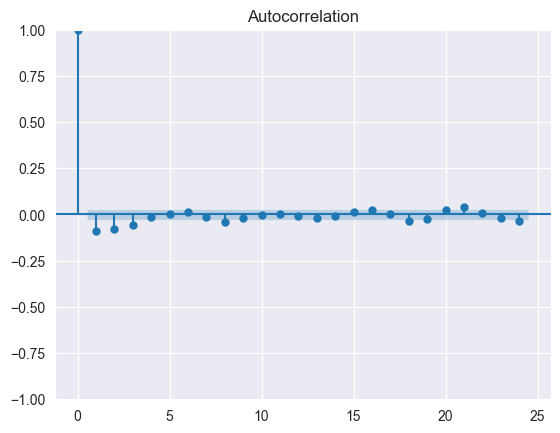

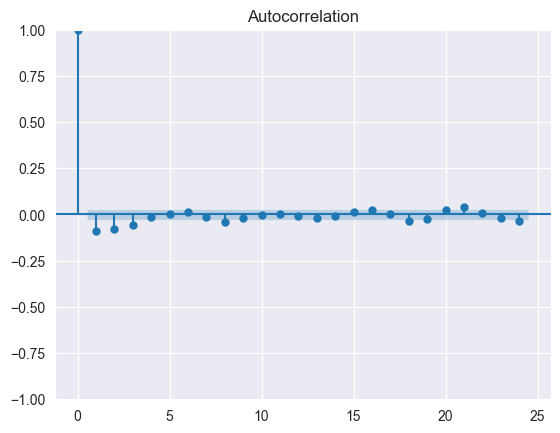

In [13]:
# TODO acf
plot_acf(x_tr_A_iC4H10, lags=24)

**Значения автокореляций признака 'A_C2H6'' и его лагами**

* `Если значения круто спадают и затем выходят на плато то это признак наличия Тренда`

In [14]:
x_tr_A_C2H6 = df_tr['A_C2H6'].dropna()

print(x_tr_A_C2H6.isna().any().any())

acf(x_tr_A_C2H6, nlags=24)



False


array([1.        , 0.99083108, 0.97717406, 0.9675482 , 0.96262971,
       0.95848804, 0.95267283, 0.94625752, 0.94138001, 0.93821393,
       0.93487628, 0.93026003, 0.92504522, 0.92095707, 0.91822835,
       0.91568594, 0.91206783, 0.90814122, 0.90467362, 0.90140232,
       0.89752053, 0.89298399, 0.88900877, 0.88514487, 0.88160514])

**плавное убывание**

    * сильная инерция
    * возможен тренд
    
**Если ACF:  долго не падает к 0 → почти всегда нужен diff.**

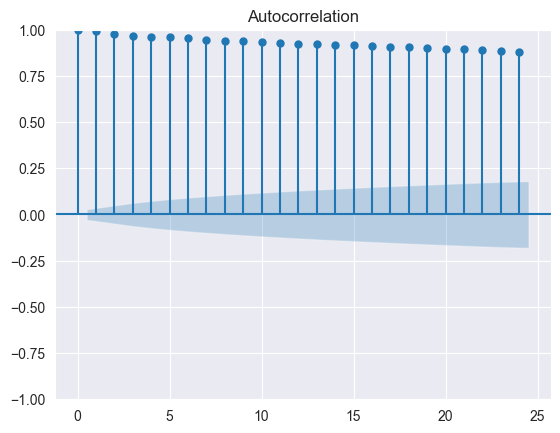

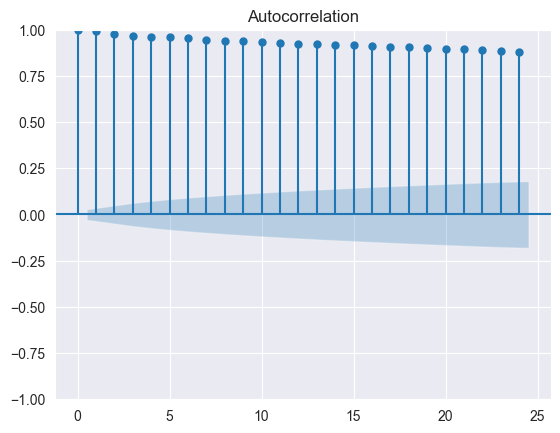

In [15]:
plot_acf(x_tr_A_C2H6, lags=24)

In [5]:
df_tr.columns

Index(['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10',
       'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'],
      dtype='object')

**Краткосрочная зависимость**

`возможна смесь краткосрочной зависимости и тренда`

`Если значения в начале спадают и затем выходят на плато то это признак наличия Тренда`

False
[1.         0.9335512  0.88530014 0.85068163 0.82553247 0.80316068
 0.78048714 0.75941449 0.74251042 0.72972671 0.71837086 0.70632538
 0.69445649 0.68352374 0.67388924 0.66398922 0.65273521 0.64027533
 0.62813287 0.61688473 0.60649303 0.59458315 0.58240423 0.56921219
 0.55502398]


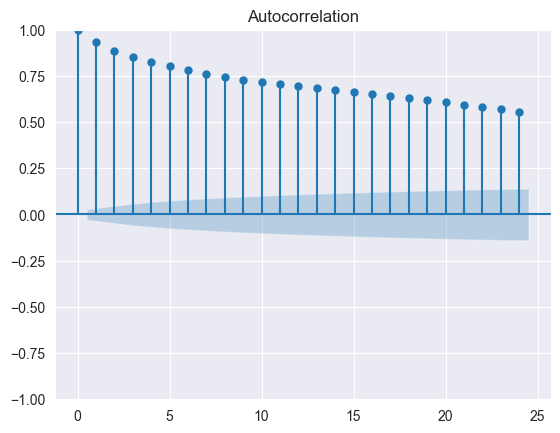

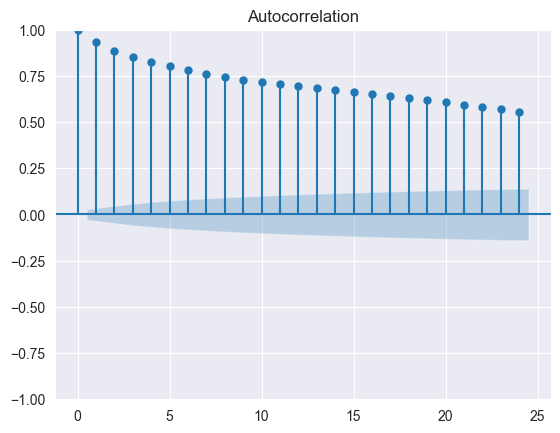

In [16]:
x_tr_A_C6H14 = df_tr['A_C6H14'].dropna()

print(x_tr_A_C6H14.isna().any().any())

print(acf(x_tr_A_C6H14, nlags=24))

plot_acf(x_tr_A_C6H14, lags=24)

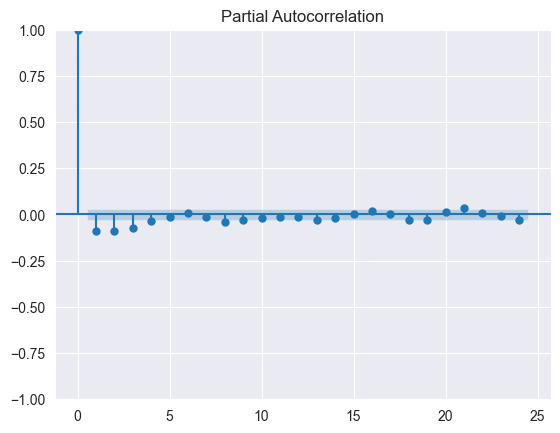

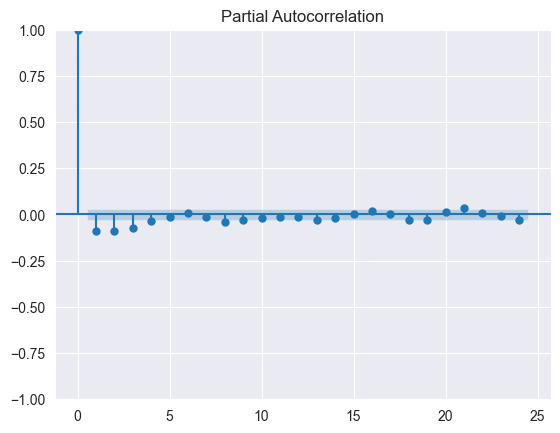

In [40]:
# TODO pacf

plot_pacf(x_tr_A_iC4H10, lags=24)

# 1 вариант

**Поиск значимых лагов через acf с параметром alpha**

    * `alpha - задёт p_value`
    * `confint - границы CI`
        * confint[:, 0] - lower bound
        * confint[:, 1] - upper bound

In [17]:
acf_vals, confint = acf(x_tr_A_C6H14, nlags=24, alpha=0.05)

print(acf_vals)

confint[:, 0]

for (low, upp), corr_val in zip(confint, acf_vals):
    print((f'low bounded : {low:2f}, value corr lag : {corr_val:2f}, upper bounded : {upp:2f}'))


# TODO lower > 0   → CI полностью выше 0 или upper < 0   → CI полностью ниже 0

[acf_vals[i]for i in range(len(confint)) if confint[i][0] > 0 or confint[i][1] < 0]


[1.         0.9335512  0.88530014 0.85068163 0.82553247 0.80316068
 0.78048714 0.75941449 0.74251042 0.72972671 0.71837086 0.70632538
 0.69445649 0.68352374 0.67388924 0.66398922 0.65273521 0.64027533
 0.62813287 0.61688473 0.60649303 0.59458315 0.58240423 0.56921219
 0.55502398]
low bounded : 1.000000, value corr lag : 1.000000, upper bounded : 1.000000
low bounded : 0.905405, value corr lag : 0.933551, upper bounded : 0.961698
low bounded : 0.838684, value corr lag : 0.885300, upper bounded : 0.931916
low bounded : 0.792245, value corr lag : 0.850682, upper bounded : 0.909119
low bounded : 0.757994, value corr lag : 0.825532, upper bounded : 0.893071
low bounded : 0.728052, value corr lag : 0.803161, upper bounded : 0.878269
low bounded : 0.698858, value corr lag : 0.780487, upper bounded : 0.862116
low bounded : 0.672073, value corr lag : 0.759414, upper bounded : 0.846756
low bounded : 0.650086, value corr lag : 0.742510, upper bounded : 0.834935
low bounded : 0.632692, value corr 

[1.0,
 0.9335511972934832,
 0.8853001382749333,
 0.850681631037021,
 0.8255324716906154,
 0.8031606830392741,
 0.7804871357938729,
 0.7594144870025932,
 0.742510418002426,
 0.7297267134670254,
 0.7183708627868474,
 0.7063253799220847,
 0.6944564886085662,
 0.6835237428221459,
 0.6738892392923955,
 0.6639892211619309,
 0.6527352095969254,
 0.6402753334690644,
 0.6281328686885944,
 0.6168847290150404,
 0.606493030158172,
 0.5945831463232385,
 0.5824042345649277,
 0.5692121883029883,
 0.5550239799631227]


# 2 вариант

**Поиск значимых лагов в ручную**

    * Вывод кортежа (lower, corr_lag, upper)

In [18]:
acf_vals = acf(x_tr_A_C6H14, nlags=24)

t = 1.95
n = len(x_tr_A_C6H14)

ci = t / np.sqrt(n)

[(lag - ci, lag, lag + ci )for lag in acf_vals]

[(0.9719967447315491, 1.0, 1.028003255268451),
 (0.9055479420250323, 0.9335511972934832, 0.9615544525619342),
 (0.8572968830064823, 0.8853001382749333, 0.9133033935433842),
 (0.8226783757685701, 0.850681631037021, 0.8786848863054719),
 (0.7975292164221645, 0.8255324716906154, 0.8535357269590663),
 (0.7751574277708232, 0.8031606830392741, 0.8311639383077251),
 (0.7524838805254219, 0.7804871357938729, 0.8084903910623238),
 (0.7314112317341422, 0.7594144870025932, 0.7874177422710441),
 (0.7145071627339751, 0.742510418002426, 0.7705136732708769),
 (0.7017234581985745, 0.7297267134670254, 0.7577299687354764),
 (0.6903676075183964, 0.7183708627868474, 0.7463741180552983),
 (0.6783221246536337, 0.7063253799220847, 0.7343286351905356),
 (0.6664532333401153, 0.6944564886085662, 0.7224597438770172),
 (0.655520487553695, 0.6835237428221459, 0.7115269980905968),
 (0.6458859840239446, 0.6738892392923955, 0.7018924945608465),
 (0.63598596589348, 0.6639892211619309, 0.6919924764303819),
 (0.624731954

# seasonal_decompose

**1D — стандартный случай, просто один столбец.**

**2D — несколько временных рядов в разных столбцах, тогда seasonal_decompose применяет разложение отдельно к каждому столбцу.**

In [34]:
# TODO trend, seasons, noise



df_tr['timestamp'] = pd.to_datetime(df_tr['timestamp'])

df_tr = df_tr.set_index('timestamp')

df_tr = df_tr.dropna()

# TODO Явно установим частоту 30 минут
# df_tr  = df_tr.asfreq('30T')  # Явно установим частоту 30 минут

# df_tr = df_tr.asfreq('D')

df_tr

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
timestamp,,,,,,,,,,
2020-01-01 04:30:00,71.055792,0.126244,5.242957,41.941480,17.064213,23.205953,4.184848,4.062079,4.110170,71.389674
2020-01-01 05:00:00,71.029881,0.111301,4.632455,39.198330,17.440245,24.331520,4.615703,4.545702,5.072316,71.792506
2020-01-01 05:30:00,71.008884,0.125176,4.730933,37.874656,17.353362,24.567692,4.847911,4.818913,5.626975,71.939558
2020-01-01 06:00:00,71.060109,0.141546,5.214231,39.763493,17.098163,23.758240,4.512244,4.429068,5.021207,72.124690
2020-01-01 06:30:00,71.067865,0.143911,5.440833,41.616510,16.964787,23.121613,4.212636,4.088066,4.347822,72.278288
...,...,...,...,...,...,...,...,...,...,...
2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355
2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066
2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367


In [35]:
df_tr['A_CH4'].isna().any()

False

**seasonal_decompose - pass только 1D**

    * res.plot()
    * res.trend
    * res.seasonal
    * res.resid
    * res.observed

In [13]:
# TODO trend, seasons, noise

'''
Атрибуты seasonal_decompose:
             * res.plot()
             * res.trend
             * res.seasonal
             * res.resid
             * res.observed
'''

df_tr['timestamp'] = pd.to_datetime(df_tr['timestamp'])

df_tr = df_tr.set_index('timestamp')

# df_tr = df_tr.dropna()

# df_tr = df_tr.asfreq('D')

print(pd.infer_freq(df_tr.index))

# print('Пропуски : \n', df_tr['A_CH4'].isna().any())

res = seasonal_decompose(df_tr.index,
                   model='additive', 
                   filt=None, 
                   period=1440, 
                   two_sided=True, 
                   extrapolate_trend=0
                   )

# df_tr.head(2)

30min


# trend

In [14]:
res.trend                                 

array([nan, nan, nan, ..., nan, nan, nan])

In [15]:
# TODO лаг по порогу

s_trend = pd.Series(res.trend)
s_trend[s_trend > 0.35]

720     1.579133e+18
721     1.579135e+18
722     1.579136e+18
723     1.579138e+18
724     1.579140e+18
            ...     
5083    1.586986e+18
5084    1.586988e+18
5085    1.586990e+18
5086    1.586992e+18
5087    1.586993e+18
Length: 4368, dtype: float64

# plot

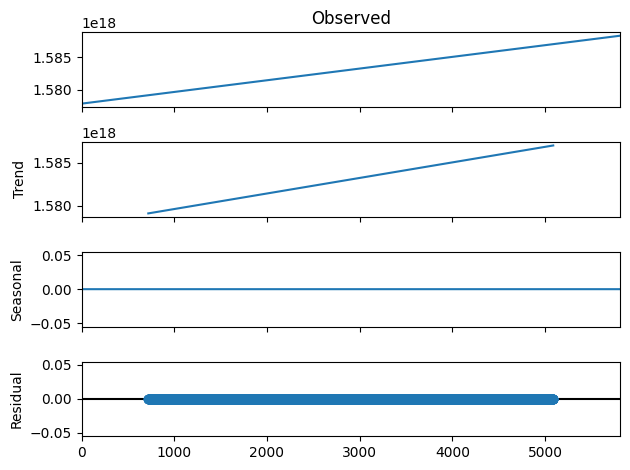

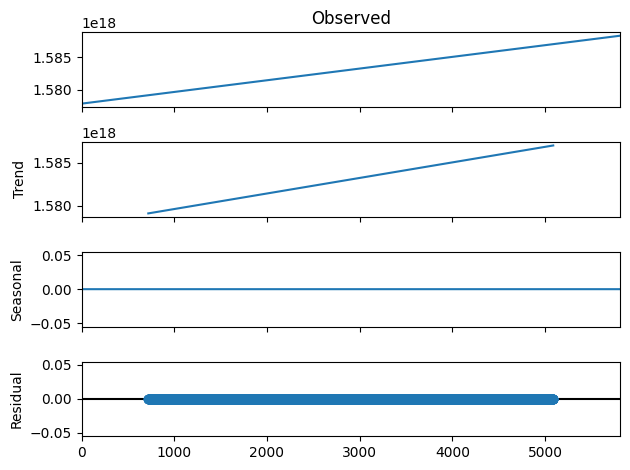

In [16]:
res.plot()

# seasonal

In [36]:
res.seasonal

timestamp
2020-01-01 04:30:00    0.000883
2020-01-01 05:00:00    0.002607
2020-01-01 05:30:00    0.002722
2020-01-01 06:00:00    0.002088
2020-01-01 06:30:00    0.001159
                         ...   
2020-04-30 21:30:00    0.001013
2020-04-30 22:00:00    0.001051
2020-04-30 22:30:00    0.000739
2020-04-30 23:00:00    0.000883
2020-04-30 23:30:00    0.002607
Name: seasonal, Length: 4730, dtype: float64

# ARDL
**dataset из statsmodels doc**

In [26]:
data = load().data
data = data[["lrm", "lry", "ibo", "ide"]]
data.tail(2)

y = np.asarray(data.lrm)
x = np.asarray(data[["lry", "ibo", "ide"]])
res = ARDL(y, 2, x, {0: 1, 1: 2, 2: 3}, trend="c").fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               ARDL(2, 1, 2, 3)   Log Likelihood                 136.252
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Wed, 04 Feb 2026   AIC                           -246.504
Time:                        11:56:37   BIC                           -220.890
Sample:                             3   HQIC                          -236.654
                                   55                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4440      0.546      4.479      0.000       1.342       3.546
y.L1           0.2695      0.139      1.944      0.059      -0.011       0.550
y.L2           0.3409      0.114      2.993      0.005       0.111       0.571
x0.L0          0.6344      0.145      4.368      0.000       0.341       0.928
x0.L1         -0.2426      0.159     -1.527      0.134      -0.563       0.078
x1.L0         -1.1316      0.359     -3.157      0.003      -1.856      -0.408
x1.L1          0.1056      0.640      0.165      0.870      -1.186       1.397
x1.L2         -0.8347      0.497     -1.679      0.101      -1.839       0.170
x2.L0          0.2849      0.614      0.464      0.645      -0.954       1.524
x2.L1          0.0433      0.805      0.054      0.957      -1.582       1.669
x2.L2          0.4429      0.770      0.575      0.568      -1.112       1.998
x2.L3          0.3671      0.515      0.713      0.480      -0.673       1.408
==============================================================================
"""

In [27]:
sel_res = ardl_select_order(
    data.lrm, 3, data[["lry", "ibo", "ide"]], 3, ic="aic", trend="c"
)
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (3, 1, 3, 2)
